In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix, r2_score,accuracy_score,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

## 1.0 Data Cleaning

### 1.1 Clean US_Elections_2020.csv

In [189]:
df_US = pd.read_csv('US_Elections_2020.csv')
df_US.head()

,text,sentiment,negative_reason
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19
3,b'Every 107 seconds an American is dying from ...,1,NaN
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN


In [190]:
# remove all html tags and attributes
df_US.loc[:,"text"] = df_US.text.apply(lambda x : re.sub(r'/<[^>]+>/','', x))

In [191]:
#replace html character codes with ASCII equivalent
from html import unescape
df_US["text"] = df_US.text.apply(lambda x :unescape(x))

In [192]:
df_US.loc[:,"text"] = df_US.text.apply(lambda x : re.sub(r'http\S+', '', x)) #remove URL

In [193]:
#remove \n
df_US.loc[:,"text"] = df_US.text.apply(lambda x :x.replace('\\n',''))

In [194]:
# Remove @users, RT and punctuation but keep hashtag
def remove_punct (df):
    df['text'] = df['text'].replace(r'@\w+','', regex=True)
    df['text'] = df['text'].str.replace("[^a-zA-Z#]", " ")
    df['text'] = df['text'].str.replace('RT', '')
    return df
df_US = remove_punct (df_US)

In [195]:
df_US.head()

,text,sentiment,negative_reason
0,b so afraid of Nov Dec and Jan Even if #Bi...,0,covid19
1,b Lord Sumption launches Recovery a new i...,0,others
2,b Uber Timing after #Biden advisors said t...,0,covid19
3,b Every seconds an American is dying from ...,1,NaN
4,b The #Democrats embrace #DiversityandInclu...,1,NaN


In [196]:
df_US.loc[:,"text"] = df_US.text.apply(lambda x : str.lower(x)) #convert all characters to lowercase

In [197]:
df_US.head()

,text,sentiment,negative_reason
0,b so afraid of nov dec and jan even if #bi...,0,covid19
1,b lord sumption launches recovery a new i...,0,others
2,b uber timing after #biden advisors said t...,0,covid19
3,b every seconds an american is dying from ...,1,NaN
4,b the #democrats embrace #diversityandinclu...,1,NaN


In [198]:
# remove stop words
stopwords = open('stop_words.txt','r',encoding="utf8").read() # read stop_words.txt
stopwords = stopwords.split('\n')
def remove_stopWords(s):
    s = ' '.join(word for word in s.split() if word not in stopwords)
    return s

df_US["text"] = df_US.text.apply(lambda x: remove_stopWords(x))

In [199]:
df_US.head()

,text,sentiment,negative_reason
0,afraid nov dec jan #bidenharris win frump mont...,0,covid19
1,lord sumption launches recovery initiative pro...,0,others
2,uber timing #biden advisors pressure #brazil s...,0,covid19
3,seconds american dying #trumpvirus #donaldtrum...,1,NaN
4,#democrats embrace #diversityandinclusion citi...,1,NaN


In [200]:
df_US.iloc[3]['text'].split()

['seconds',
 'american',
 'dying',
 '#trumpvirus',
 '#donaldtrump',
 'thinks',
 'success',
 '#joebiden']

In [201]:
df_US['negative_reason'].isnull().value_counts()

True     1288
False    1264
Name: negative_reason, dtype: int64

### 1.2 Clean sentiment_analysis.csv

In [15]:
df_sentiment = pd.read_csv('sentiment_analysis.csv')
df_sentiment.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


In [16]:
#remove all html tags and attributes
df_sentiment["text"] = df_sentiment.text.apply(lambda x : re.sub(r'/<[^>]+>/','', x))

In [17]:
#replace html character codes with ASCII equivalent
from html import unescape
df_sentiment["text"] = df_sentiment.text.apply(lambda x :unescape(x))

In [18]:
df_sentiment.loc[:,"text"] = df_sentiment.text.apply(lambda x : re.sub(r'http\S+', '', x)) #remove URL

In [19]:
# remove accented characters
import unicodedata
def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text
df_sentiment["text"] = df_sentiment.text.apply(lambda x :remove_accented_chars(x))

In [20]:
df_sentiment = remove_punct(df_sentiment)#remove punctuations, @users, RT, keep hashtag

In [21]:
df_sentiment.loc[:,"text"] = df_sentiment.text.apply(lambda x : str.lower(x)) #convert all characters to lowercase

In [22]:
df_sentiment.head()

,ID,text,label
0,7.680980e+17,josh jenkins is looking forward to tab breeder...,1
1,7.680980e+17,congratulations pakistan on becoming #no te...,1
2,7.680980e+17,this september is taking you to maine men...,1
3,7.680980e+17,newly painted walls thanks a million to ou...,1
4,7.680980e+17,excited to announce as of july fescho...,1


In [23]:
#remove stopwords
df_sentiment["text"] = df_sentiment.text.apply(lambda x: remove_stopWords(x))

In [24]:
df_sentiment.head()

,ID,text,label
0,7.680980e+17,josh jenkins forward tab breeders crown super ...,1
1,7.680980e+17,congratulations pakistan #no testteam odds #ji...,1
2,7.680980e+17,september maine mendozas surprise thanksgiving...,1
3,7.680980e+17,newly painted walls custodial painters summer ...,1
4,7.680980e+17,excited july feschotte lab will relocating mbg,1


In [25]:
df_sentiment.iloc[0]['text'].split()

['josh', 'jenkins', 'forward', 'tab', 'breeders', 'crown', 'super', 'sunday']

## 2.0 Exploratory Analysis

In [188]:
#look for some relevant words to determine political affiliations
count_demo = 0
count_repub = 0
count_others = 0
for i in range (df_US['text'].shape[0]):
    x = df_US.iloc[i]['text']
    if 'maga' in x or 'hunterbiden' in x:
        count_repub+=1
        df_US.loc[i,'Political Affiliation'] = 'Republican Party'
    elif 'bidenharris' in x or 'voteblue' in x or 'trumpcrimefamily' in x or 'votehimout'in x or 'trumpvirus' in x or 'bluewave' in x or 'democrats' in x:
        count_demo+=1
        df_US.loc[i,'Political Affiliation'] = 'Democratic Party'
    else:
        count_others+=1
        df_US.loc[i,'Political Affiliation'] = 'Others'
print(count_demo)
print(count_repub)
print(count_others)

567
151
1834


In [166]:
df_US.head(10)

,text,sentiment,negative_reason,Political Affiliation
0,afraid nov dec jan #bidenharris win frump mont...,0,covid19,Democratic Party
1,lord sumption launches recovery initiative pro...,0,others,Others
2,uber timing #biden advisors pressure #brazil s...,0,covid19,Others
3,seconds american dying #trumpvirus #donaldtrum...,1,NaN,Democratic Party
4,#democrats embrace #diversityandinclusion citi...,1,NaN,Others
5,accelerating rising #americans killed #trumpvirus,0,discrimination,Democratic Party
6,dead americans day times number died benghazi ...,0,discrimination,Others
7,#covid #coronavirus #coronavirusuk #covid #ukl...,1,NaN,Democratic Party
8,reason rallies losing,0,corruption,Others
9,concerned #hunterbiden trump ass kisser human ...,0,covid19,Republican Party


Text(0.5, 1.0, 'Distribution of the political affiliations')

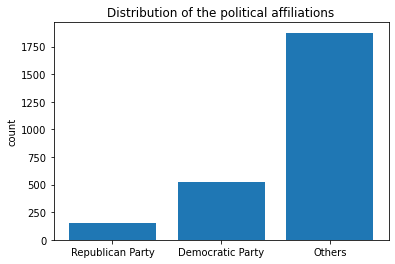

In [27]:
name_party = ['Republican Party','Democratic Party','Others']
count_party = [count_repub,count_demo,count_others]
plt.bar(name_party,count_party)
plt.ylabel('count')
plt.title('Distribution of the political affiliations')

#### Democratic party has far more supporters than republican party.

#### plot the distribution of sentiment score for the 2020 US election tweets

Text(0.5, 1.0, 'sentiment score distribution for 2020 US election tweets')

<Figure size 864x432 with 0 Axes>

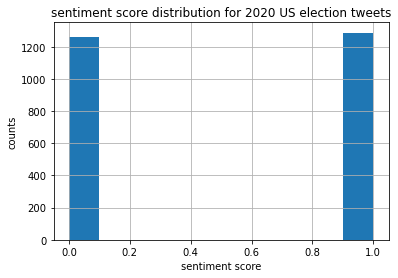

In [28]:
fig = plt.figure(figsize=(12,6))
df_US.hist('sentiment')
plt.xlabel('sentiment score')
plt.ylabel('counts')
plt.title('sentiment score distribution for 2020 US election tweets')

In [29]:
df_US.sentiment.value_counts()

1    1288
0    1264
Name: sentiment, dtype: int64

#### In 2020 US election tweets, positive tweets and negative tweets are almost evenly distributed, the number of positive tweets is slightly higher.

#### plot the distribution of sentiment score for the generic tweets

Text(0.5, 1.0, 'sentiment score distribution for generic tweets')

<Figure size 864x432 with 0 Axes>

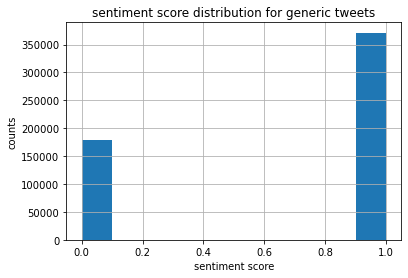

In [30]:
fig = plt.figure(figsize=(12,6))
df_sentiment.hist('label')
plt.xlabel('sentiment score')
plt.ylabel('counts')
plt.title('sentiment score distribution for generic tweets')

In [31]:
df_sentiment.label.value_counts()

1    371341
0    179050
Name: label, dtype: int64

#### In generic tweets, the number of positive tweets is significantly higher than the number of negative tweets, meaning people generally post positive tweets.

## 3.0 Model preparation

In [46]:
df_sentiment.head()

,ID,text,label
0,7.680980e+17,josh jenkins forward tab breeders crown super ...,1
1,7.680980e+17,mianusmanjaved congratulations pakistan notest...,1
2,7.680980e+17,pepalerts september yesmag maine mendozas surp...,1
3,7.680980e+17,davidgaibis newly painted walls custodial pain...,1
4,7.680980e+17,cedricfeschotte excited july feschotte lab wi...,1


### 3.1 Represent text as TF (Bag of Words) and apply different algorithms

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

def text_processing(text, is_tfidf):
    vectorizer = TfidfVectorizer(stop_words = 'english', 
                                 use_idf = is_tfidf, 
                                 max_features = 500, 
                                 ngram_range = (1,1)).fit(text)
    return vectorizer

In [35]:
vectorizer = text_processing(df_sentiment['text'], False) #False indicates TF
X_tf = vectorizer.transform(df_sentiment['text'])
y = df_sentiment.label
pd.DataFrame(data=X_tf.toarray(),columns=vectorizer.get_feature_names())

,absolutely,account,adorable,af,ago,ain,album,aldub,amazing,america,...,worst,wow,wrong,wtf,ya,yeah,year,years,yesterday,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.57735,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
#split data
from sklearn.model_selection import train_test_split
X_train_tf, X_test_tf, y_train, y_test = train_test_split(X_tf,y,test_size=0.3,random_state=42)

In [38]:
#split the train data again to reduce the running time
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train_tf,y_train,test_size=0.3,random_state=42)

In [40]:
#apply logistic regression
from sklearn.linear_model import LogisticRegression
log_tf = LogisticRegression(max_iter=386000)
log_tf.fit(X_train1,y_train1)

LogisticRegression(max_iter=386000)

In [43]:
#apply knn
from sklearn.neighbors import KNeighborsClassifier
# set initial n as the squareroot of the training size
knn_tf = KNeighborsClassifier(n_neighbors=int(np.sqrt(X_train1.shape[0])), p=2, metric='euclidean')
knn_tf.fit(X_train1,y_train1)

KNeighborsClassifier(metric='euclidean', n_neighbors=519)

In [45]:
#apply Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb_tf = GaussianNB()
nb_tf.fit(X_train1.toarray(), y_train1)

GaussianNB()

In [77]:
#apply SVM
from sklearn.svm import SVC
svm_tf = SVC(gamma='auto')
svm_tf.fit(X_train1, y_train1)

SVC(gamma='auto')

In [48]:
#apply decision tree
from sklearn.tree import DecisionTreeClassifier
tree_tf = DecisionTreeClassifier()
tree_tf.fit(X_train1, y_train1)

DecisionTreeClassifier()

In [87]:
#apply random forest
from sklearn.ensemble import RandomForestClassifier
rf_tf = RandomForestClassifier()
rf_tf.fit(X_train1, y_train1)

RandomForestClassifier()

In [57]:
#apply gradient boosting method
from sklearn.ensemble import GradientBoostingClassifier # I didn't use XGboost here because
                                                        # I cannot install it on My Mac...
gb_tfidf = GradientBoostingClassifier()
gb_tfidf.fit(X_train1, y_train1)

GradientBoostingClassifier()

### 3.2 Represent text as TF-IDF and apply different algorithms

In [59]:
vectorizer = text_processing(df_sentiment['text'], True) #False indicates TF-IDF
X_tfidf = vectorizer.transform(df_sentiment['text'])
y = df_sentiment.label
pd.DataFrame(data=X_tfidf.toarray(),columns=vectorizer.get_feature_names())

,absolutely,account,adorable,af,ago,ain,album,aldub,amazing,america,...,worst,wow,wrong,wtf,ya,yeah,year,years,yesterday,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.560836,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
#split data
from sklearn.model_selection import train_test_split
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf,y,test_size=0.3,random_state=42)

In [61]:
#split the train data again to reduce the running time
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_tfidf,y_train,test_size=0.3,random_state=42)

In [63]:
#apply logistic regression
from sklearn.linear_model import LogisticRegression
log_tfidf = LogisticRegression(max_iter=386000)
log_tfidf.fit(X_train2,y_train2)

LogisticRegression(max_iter=386000)

In [122]:
#apply knn
from sklearn.neighbors import KNeighborsClassifier
knn_tfidf = KNeighborsClassifier(n_neighbors=int(np.sqrt(X_train2.shape[0])), p=2, metric='euclidean')
knn_tfidf.fit(X_train2,y_train2)

KNeighborsClassifier(metric='euclidean', n_neighbors=519)

In [65]:
#apply Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb_tfidf = GaussianNB()
nb_tfidf.fit(X_train2.toarray(), y_train2)

GaussianNB()

In [78]:
#apply SVM
from sklearn.svm import SVC
svm_tfidf = SVC(gamma='auto')
svm_tfidf.fit(X_train2, y_train2)

SVC(gamma='auto')

In [66]:
#apply decision tree
from sklearn.tree import DecisionTreeClassifier
tree_tfidf = DecisionTreeClassifier()
tree_tfidf.fit(X_train2, y_train2)

DecisionTreeClassifier()

In [88]:
#apply random forest
from sklearn.ensemble import RandomForestClassifier
rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(X_train2, y_train2)

RandomForestClassifier()

In [137]:
#apply gradient boosting method
from sklearn.ensemble import GradientBoostingClassifier  # I didn't use XGboost here because
                                                        # I cannot install it on My Mac...
gb_tfidf = GradientBoostingClassifier()
gb_tfidf.fit(X_train2, y_train2)

GradientBoostingClassifier()

## 4.0 Model implementation

### 4.1 Accuracy of different algorithms for Bag of Words method

In [42]:
#accuracy for logistic regression using bag of words
from sklearn.metrics import accuracy_score
predictions = log_tf.predict(X_test_tf)
score = accuracy_score(y_test,predictions)
print ('Test accuracy for logistic regression using bag of words is {}'.format(score*100))

Test accuracy for logistic regression using bag of words is 89.75096597584758


In [44]:
#accuracy for knn using bag of words
predictions = knn_tf.predict(X_test_tf)
score = accuracy_score(y_test,predictions)
print ('Test accuracy for knn using bag of words is {}'.format(score*100))

Test accuracy for knn is 82.73053210431328


In [47]:
#accuracy for Naive Bayes using bag of words
predictions = nb_tf.predict(X_test_tf.toarray())
score = accuracy_score(y_test,predictions)
print ('Test accuracy for Naive Bayes using bag of words is {}'.format(score*100))

Test accuracy for Naive Bayes using bag of words is 84.67035695684298


In [79]:
#accuracy for svm using bag of words
predictions = svm_tf.predict(X_test_tf)
score = accuracy_score(y_test,predictions)
print ('Test accuracy for SVM using bag of words is {}'.format(score*100))

Test accuracy for SVM using bag of words is 89.07508569628992


In [49]:
#accuracy for decision tree using bag of words
predictions = tree_tf.predict(X_test_tf)
score = accuracy_score(y_test,predictions)
print ('Test accuracy for Decision Tree using bag of words is {}'.format(score*100))

Test accuracy for Decision Tree using bag of words is 89.41908211097518


In [89]:
#accuracy for random forest using bag of words
predictions = rf_tf.predict(X_test_tf)
score = accuracy_score(y_test,predictions)
print ('Test accuracy for Random Forest using bag of words is {}'.format(score*100))

Test accuracy for Random Forest using bag of words is 90.02228709165566


In [58]:
#accuracy for Gradient Boosting using bag of words
predictions = gb_tf.predict(X_test_tf)
score = accuracy_score(y_test,predictions)
print ('Test accuracy for Gradient Boosting using bag of words is {}'.format(score*100))

Test accuracy for Gradient Boosting using bag of words is 79.27300476023208


### 4.2 Accuracy of different algorithms for TF-IDF method

In [69]:
#accuracy for logistic regression using tfidf
from sklearn.metrics import accuracy_score
predictions = log_tfidf.predict(X_test_tfidf)
score = accuracy_score(y_test,predictions)
print ('Test accuracy for logistic regression using TFIDF is {}'.format(score*100))

Test accuracy for logistic regression using TFIDF is 89.7624728981698


In [123]:
#accuracy for knn using tfidf
predictions = knn_tfidf.predict(X_test_tfidf)
score = accuracy_score(y_test,predictions)
print ('Test accuracy for Knn using TFIDF is {}'.format(score*100))

Test accuracy for Knn using TFIDF is 80.85611502077302


In [72]:
#accuracy for Naive Bayes using tfidf
predictions = nb_tfidf.predict(X_test_tfidf.toarray())
score = accuracy_score(y_test,predictions)
print ('Test accuracy for Naive Bayes using TFIDF is {}'.format(score*100))

Test accuracy for Naive Bayes using TFIDF is 83.76797199578483


In [80]:
#accuracy for svm using tfidf
predictions = svm_tfidf.predict(X_test_tfidf)
score = accuracy_score(y_test,predictions)
print ('Test accuracy for SVM using TFIDF is {}'.format(score*100))

Test accuracy for SVM using TFIDF is 88.7062585544883


In [74]:
#accuracy for decision tree using tfidf
predictions = tree_tfidf.predict(X_test_tfidf)
score = accuracy_score(y_test,predictions)
print ('Test accuracy for Decision Tree using TFIDF is {}'.format(score*100))

Test accuracy for Decision Tree using TFIDF is 89.20468997928754


In [125]:
#accuracy for random forest using tfidf
predictions = rf_tfidf.predict(X_test_tfidf)
score = accuracy_score(y_test,predictions)
print ('Test accuracy for Random Forest using TFIDF is {}'.format(score*100))

Test accuracy for Random Forest using TFIDF is 90.06710352596326


In [138]:
#accuracy for Gradient Boosting using tfidf
predictions = gb_tfidf.predict(X_test_tfidf)
score = accuracy_score(y_test,predictions)
print ('Test accuracy for Gradient Boosting using TFIDF is {}'.format(score*100))

Test accuracy for Gradient Boosting using TFIDF is 79.28814544749815


In [128]:
#summarize results in a table
import pandas as pd
results = pd.DataFrame({"Model":["Logistic Regression", "KNN","Naive Bayes","SVM","Decision Tree","Random Forest","Gradient Boosting","Logistic Regression", "KNN","Naive Bayes","SVM","Decision Tree","Random Forest","Gradient Boosting"]})
results["Bag of word"]= [1,1,1,1,1,1,1,0,0,0,0,0,0,0]
results["TF-IDF"]= [0,0,0,0,0,0,0,1,1,1,1,1,1,1]
results["Test Accuracy"] =[89.75,82.73,84.67,89.07,89.42,90.02,79.27,89.76,80.85,83.76,88.70,89.20,90.06,79.28]

print ("Best Testing Accuracy is ", max(results['Test Accuracy']))
results

Best Testing Accuracy is  90.06


,Model,Bag of word,TF-IDF,Test Accuracy
0,Logistic Regression,1,0,89.75
1,KNN,1,0,82.73
2,Naive Bayes,1,0,84.67
3,SVM,1,0,89.07
4,Decision Tree,1,0,89.42
5,Random Forest,1,0,90.02
6,Gradient Boosting,1,0,79.27
7,Logistic Regression,0,1,89.76
8,KNN,0,1,80.85
9,Naive Bayes,0,1,83.76


#### we can see the best model is Random Forest using TF-IDF, with the highest accuracy 90.06%. And then we apply the model on US election dataset to predict sentiment label.

### 4.3 Best model performance on US Election Dataset

In [170]:
# represent data using bag of words
vectorizer = text_processing(df_US['text'], False) #False indicates TF
X_tf1 = vectorizer.transform(df_US['text'])
y1 = df_US.sentiment

pd.DataFrame(data=X_tf1.toarray(),columns=vectorizer.get_feature_names()).head()

,absolutely,accelerating,ads,afraid,ago,ahead,allowed,america,american,americans,...,worst,wow,wrong,wtf,yeah,year,years,yelling,yesterday,young
0,0.0,0.0,0.0,0.447214,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.408248,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [171]:
# split data
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_tf1, y1, test_size=0.3, random_state=42)

In [97]:
# represent data using TFIDF
vectorizer = text_processing(df_US['text'], True) #False indicates TF
X_tfidf1 = vectorizer.transform(df_US['text'])
y1 = df_US.sentiment

pd.DataFrame(data=X_tfidf1.toarray(),columns=vectorizer.get_feature_names()).head()

,absolutely,accelerating,ads,afraid,ago,ahead,allowed,america,american,americans,...,worst,wow,wrong,wtf,yeah,year,years,yelling,yesterday,young
0,0.0,0.0,0.0,0.528531,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.365808,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
# split data
X_train_us1, X_test_us1, y_train_us1, y_test_us1 = train_test_split(X_tfidf1, y1, test_size=0.3, random_state=42)

In [99]:
#accuracy for random forest using bag of words
prediction_tf = rf_tf.predict(X_test_us)
accuracy_tf = accuracy_score(y_test_us, prediction_tf) 
print ("Test Accuracy for 2020 Election dataset using bag-of-word is ", accuracy_tf)

Test Accuracy for 2020 Election dataset using bag-of-word is  0.48433420365535246


In [101]:
#accuracy for random forest using TFIDF
prediction_tfidf = rf_tfidf.predict(X_test_us1)
accuracy_tfidf = accuracy_score(y_test_us1, prediction_tfidf) 
print ("Test Accuracy for 2020 Election dataset using TF-IDF is ", accuracy_tfidf)

Test Accuracy for 2020 Election dataset using TF-IDF is  0.47780678851174935


#### Random forest's performance drops significantly on the US election dataset. And we visualize predicted labels and true labels for each party to see the difference.

In [174]:
#create df with true and predicted labels of random forest with bag of words
df_prediction = pd.DataFrame(prediction_tf,columns=['Predicted Label'])
df_prediction['True Label'] = y_test_us.values
df_prediction['Political Affiliation'] = df_US.loc[y_test_us.index,['Political Affiliation']].values
df_prediction

,Predicted Label,True Label,Political Affiliation
0,1,0,Others
1,0,1,Others
2,0,0,Others
3,0,1,Others
4,1,1,Others
...,...,...,...
761,1,1,Others
762,1,0,Others
763,0,0,Republican Party
764,0,1,Others


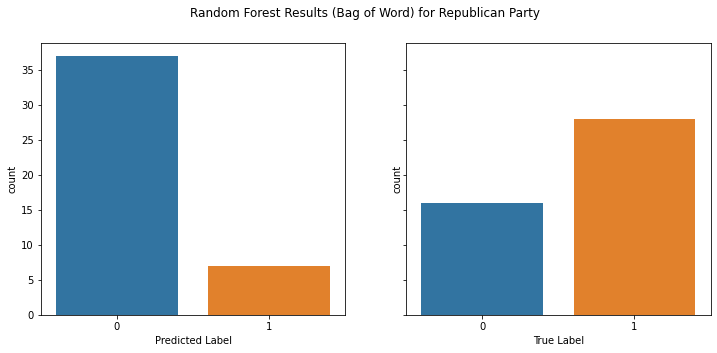

In [187]:
#use countplot to visualize predicted labels and true label for Republican Party
import seaborn as sns
df_rep = df_prediction[df_prediction['Political Affiliation']=='Republican Party']

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Random Forest Results (Bag of Word) for Republican Party')

sns.countplot(ax=axes[0], x = 'Predicted Label', data = df_rep)
sns.countplot(ax=axes[1],x = 'True Label', data = df_rep)

In [230]:
df_rep

,Predicted Label,True Label,Political Affiliation
27,0,1,Republican Party
36,0,1,Republican Party
48,0,0,Republican Party
97,0,1,Republican Party
137,0,1,Republican Party
173,0,1,Republican Party
178,1,0,Republican Party
200,0,0,Republican Party
201,1,1,Republican Party
202,0,1,Republican Party


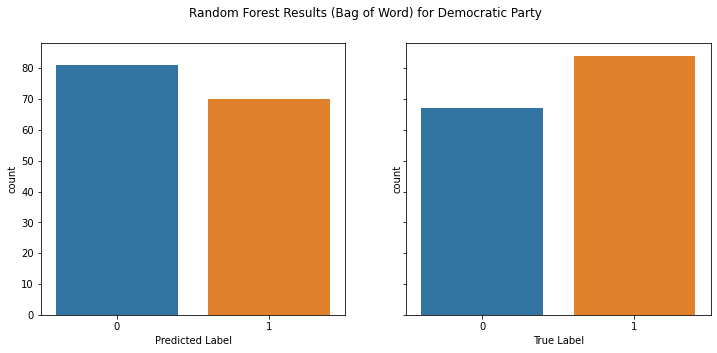

In [178]:
#use countplot to visualize predicted labels and true label for Democratic Party
import seaborn as sns
df_demo = df_prediction[df_prediction['Political Affiliation']=='Democratic Party']

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Random Forest Results (Bag of Word) for Democratic Party')

sns.countplot(ax=axes[0], x = 'Predicted Label', data = df_demo)
sns.countplot(ax=axes[1],x = 'True Label', data = df_demo)

In [182]:
#create df with true and predicted labels of random forest with TFIDF
df_prediction1 = pd.DataFrame(prediction_tfidf,columns=['Predicted Label'])
df_prediction1['True Label'] = y_test_us1.values
df_prediction1['Political Affiliation'] = df_US.loc[y_test_us1.index,['Political Affiliation']].values
df_prediction1

,Predicted Label,True Label,Political Affiliation
0,1,0,Others
1,0,1,Others
2,0,0,Others
3,0,1,Others
4,1,1,Others
...,...,...,...
761,1,1,Others
762,1,0,Others
763,0,0,Republican Party
764,0,1,Others


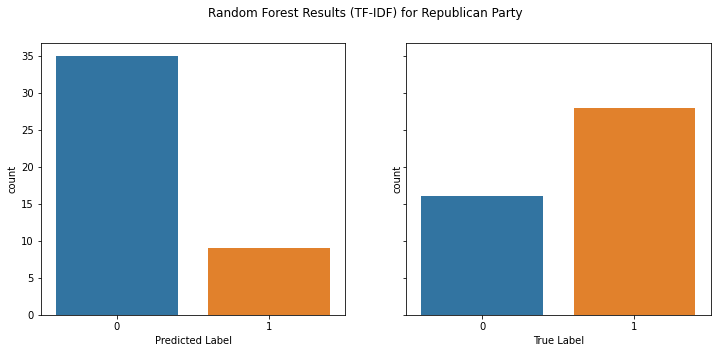

In [184]:
#use countplot to visualize predicted labels and true label for Republican Party
import seaborn as sns
df_rep = df_prediction1[df_prediction1['Political Affiliation']=='Republican Party']
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Random Forest Results (TF-IDF) for Republican Party')

sns.countplot(ax=axes[0], x = 'Predicted Label', data = df_rep)
sns.countplot(ax=axes[1],x = 'True Label', data = df_rep)

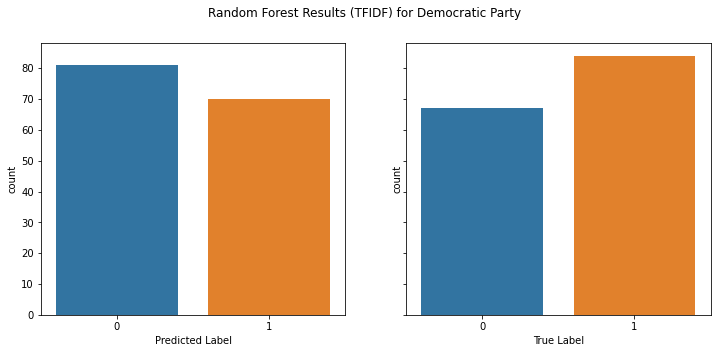

In [186]:
#use countplot to visualize predicted labels and true label for Democratic Party
import seaborn as sns
df_demo = df_prediction1[df_prediction1['Political Affiliation']=='Democratic Party']

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Random Forest Results (TFIDF) for Democratic Party')

sns.countplot(ax=axes[0], x = 'Predicted Label', data = df_demo)
sns.countplot(ax=axes[1],x = 'True Label', data = df_demo)

#### The test accurcy is much lower on US election dataset. It is because features of bag of words and TFIDF in election dataset are quite different from those in the sentiment dataset.

### 4.4 Negative tweets analysis

In [129]:
#get negative tweets
df_negative = df_US[df_US['sentiment']==0]
df_negative.head()

,text,sentiment,negative_reason
0,afraid nov dec jan #bidenharris win frump mont...,0,covid19
1,lord sumption launches recovery initiative pro...,0,others
2,uber timing #biden advisors pressure #brazil s...,0,covid19
5,accelerating rising #americans killed #trumpvirus,0,discrimination
6,dead americans day times number died benghazi ...,0,discrimination


In [130]:
df_negative['negative_reason'].value_counts()

covid19           405
crime             222
corruption        220
discrimination    215
others            202
Name: negative_reason, dtype: int64

In [27]:
# one hot encoding for negative_reason
dummies_reason = pd.get_dummies(df_negative['negative_reason'], prefix='')
tempDF = pd.concat([df_negative, dummies_reason], axis=1)
tempDF.head()

,text,sentiment,negative_reason,_corruption,_covid19,_crime,_discrimination,_others
0,robreiner afraid nov dec jan bidenharris winfr...,0,covid19,0,1,0,0,0
1,sueck lord sumption launches recovery initiati...,0,others,0,0,0,0,1
2,walidphares uber timing biden advisors pressur...,0,covid19,0,1,0,0,0
5,accelerating rising americans killed trumpvirus,0,discrimination,0,0,0,1,0
6,realdonaldtrump dead americans day times num...,0,discrimination,0,0,0,1,0


In [161]:
# label encoding for negative_reason
reason_encode = {'covid19':0,
               'crime':1,
               'corruption':2,
               'discrimination':3,
               'others': 4
               }
df_negative.loc[:,'reason_Encoded'] = df_negative.loc[:,'negative_reason'].map(reason_encode)
df_negative.loc[:,'reason_Encoded']= df_negative.loc[:,'reason_Encoded'].astype(int)
df_negative.reason_Encoded.unique()
df_negative.head(5)

,text,sentiment,negative_reason,reason_Encoded
0,afraid nov dec jan #bidenharris win frump mont...,0,covid19,0
1,lord sumption launches recovery initiative pro...,0,others,4
2,uber timing #biden advisors pressure #brazil s...,0,covid19,0
5,accelerating rising #americans killed #trumpvirus,0,discrimination,3
6,dead americans day times number died benghazi ...,0,discrimination,3


### 4.4.1 Apply algorithms on Bag of Words

In [219]:
#use tfidf to represent text
vectorizer = text_processing(df_negative['text'], False) #False indicates TF
us_tf = vectorizer.transform(df_negative['text'])
y_us = df_negative.reason_Encoded
pd.DataFrame(data=us_tf.toarray(),columns=vectorizer.get_feature_names()).head()

,absentee,accelerating,account,actual,administration,ads,afraid,ahead,allowed,america,...,worse,worst,wrong,wtf,yeah,year,years,yelling,yesterday,young
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.408248,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.447214,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
#split data
us_train_tf, us_test_tf, y_train_us, y_test_us = train_test_split(us_tf,y_us,test_size=0.3, random_state=42)

In [227]:
#hyperparameter tuning for Logistic Regression using grid search

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True) #apply 10-fold cv

solver_list =  ['liblinear','saga','newton-cg','lbfgs']
C_list = [0.001,0.01, 0.1, 1, 10, 100, 1000]

param_grid = {'C': C_list, 'solver': solver_list}

log_us = LogisticRegression(max_iter=3000,multi_class='multinomial') # apply one vs one multiclass classification
log_gs = GridSearchCV(log_us, param_grid ,cv=cv)
log_gs.fit(us_train_tf,y_train_us)

#apply best model
best_log = log_gs.best_estimator_
y_test_pred = best_log.predict(us_test_tf)
log_test_accuracy = accuracy_score(y_test_us,y_test_pred)

print("tuned hyperparameters :(best parameters) ",log_gs.best_params_)
print("best train accuracy :", log_gs.best_score_)
print("test accuracy on best model :", log_test_accuracy)

tuned hyperparameters :(best parameters)  {'C': 0.1, 'solver': 'saga'}
best train accuracy : 0.3427477017364658
test accuracy on best model : 0.3


In [151]:
#hyperparameter tuning for Knn using grid search

cv = StratifiedKFold(n_splits=10, shuffle=True)
gs = {'n_neighbors': np.arange(1,40),
      'p': [1,2],
      'weights': ['uniform', 'distance']}

knn_gs = KNeighborsClassifier()
knn_param_search = GridSearchCV(knn_gs,gs,cv=cv)
knn_param_search.fit(us_train_tf,y_train_us)

#apply best model
best_knn = knn_param_search.best_estimator_
knn_y_pred = best_knn.predict(us_test_tf)
knn_test_accuracy = accuracy_score(y_test_us,knn_y_pred)

print("tuned hyperparameters :(best parameters) ",knn_param_search.best_params_)
print("best train accuracy :", knn_param_search.best_score_)
print("test accuracy on best model :", knn_test_accuracy)

#print(classification_report(y_test_us, knn_test_accuracy))

tuned hyperparameters :(best parameters)  {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
best train accuracy : 0.36423646578140967
test accuracy on best model : 0.3263157894736842


In [228]:
#hyperparameter tuning for SVM using grid search

cv = StratifiedKFold(n_splits=10, shuffle=True)
param = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [10000],
    'kernel':['linear', 'rbf', 'sigmoid'],
    'gamma' :[0.001, 0.01, 0.1, 0.5, 1, 1.5,10]
}

svc_us = SVC(decision_function_shape='ovo')# apply one vs one multiclass classification
GSCV_svc = GridSearchCV(svc_us, param_grid=param, scoring='accuracy', cv=cv)
GSCV_svc.fit(us_train_tf,y_train_us)

#apply best model
best_svc = GSCV_svc.best_estimator_
svc_y_pred = best_svc.predict(us_test_tf)
svc_test_accuracy = accuracy_score(y_test_us,svc_y_pred)

GSCV_svc.best_params_ , GSCV_svc.best_score_
print("tuned hyperparameters :(best parameters) ",GSCV_svc.best_params_ )
print("best train accuracy :", GSCV_svc.best_score_)
print("test accuracy on best model:", svc_test_accuracy)
#print(classification_report(y_test, svc_test_accuracy))

tuned hyperparameters :(best parameters)  {'C': 1, 'gamma': 1.5, 'kernel': 'rbf', 'max_iter': 10000}
best train accuracy : 0.37104187946884576
test accuracy on best model: 0.3473684210526316


### 4.4.2 Apply algorithms on TF-IDF

In [222]:
#use tfidf to represent text
vectorizer = text_processing(df_negative['text'], True) #True indicates TF-IDF
us_tfidf = vectorizer.transform(df_negative['text'])
y_us = df_negative.reason_Encoded
pd.DataFrame(data=us_tfidf.toarray(),columns=vectorizer.get_feature_names()).head()

,absentee,accelerating,account,actual,administration,ads,afraid,ahead,allowed,america,...,worse,worst,wrong,wtf,yeah,year,years,yelling,yesterday,young
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.459988,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.470458,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [223]:
#split data
us_train_tfidf, us_test_tfidf, y_train_us, y_test_us = train_test_split(us_tfidf,y_us,test_size=0.3,random_state=42)

In [224]:
#hyperparameter tuning for Logistic Regression using grid search

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

solver_list =  ['liblinear','saga','newton-cg','lbfgs']
C_list = [0.001,0.01, 0.1, 1, 10, 100, 1000]

param_grid = {'C': C_list, 'solver': solver_list}

log_us = LogisticRegression(max_iter=3000,multi_class='multinomial') # apply one vs one multiclass classification
log_gs = GridSearchCV(log_us, param_grid ,cv=cv)
log_gs.fit(us_train_tfidf,y_train_us)

#apply best model
best_log = log_gs.best_estimator_
y_test_pred = best_log.predict(us_test_tfidf)
log_test_accuracy = accuracy_score(y_test_us,y_test_pred)

print("tuned hyperparameters :(best parameters) ",log_gs.best_params_)
print("best train accuracy :", log_gs.best_score_)
print("test accuracy on best model :", log_test_accuracy)

tuned hyperparameters :(best parameters)  {'C': 0.1, 'solver': 'saga'}
best train accuracy : 0.3438968335035751
test accuracy on best model : 0.3


In [158]:
#hyperparameter tuning for Knn using grid search

cv = StratifiedKFold(n_splits=10, shuffle=True)
gs = {'n_neighbors': np.arange(1,40),
      'p': [1,2],
      'weights': ['uniform', 'distance']}

knn_gs = KNeighborsClassifier()
knn_param_search = GridSearchCV(knn_gs,gs,cv=cv)
knn_param_search.fit(us_train_tfidf,y_train_us)

#apply best model
best_knn = knn_param_search.best_estimator_
knn_y_pred = best_knn.predict(us_test_tfidf)
knn_test_accuracy = accuracy_score(y_test_us,knn_y_pred)

print("tuned hyperparameters :(best parameters) ",knn_param_search.best_params_)
print("best train accuracy :", knn_param_search.best_score_)
print("test accuracy on best model :", knn_test_accuracy)
#print(classification_report(y_test_us, knn_test_accuracy))

tuned hyperparameters :(best parameters)  {'n_neighbors': 16, 'p': 1, 'weights': 'distance'}
best train accuracy : 0.37093973442288053
test accuracy on best model : 0.32105263157894737


In [159]:
#hyperparameter tuning for SVM using grid search

cv = StratifiedKFold(n_splits=10, shuffle=True)
param = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [10000],
    'kernel':['linear', 'rbf', 'sigmoid'],
    'gamma' :[0.001, 0.01, 0.1, 0.5, 1, 1.5,10]
}

svc_us = SVC(decision_function_shape='ovo') # apply one vs one multiclass classification
GSCV_svc = GridSearchCV(svc_us, param_grid=param, scoring='accuracy', cv=cv)
GSCV_svc.fit(us_train_tfidf,y_train_us)

#apply best model
best_svc = GSCV_svc.best_estimator_
svc_y_pred = best_svc.predict(us_test_tfidf)
svc_test_accuracy = accuracy_score(y_test_us,svc_y_pred)

GSCV_svc.best_params_ , GSCV_svc.best_score_
print("tuned hyperparameters :(best parameters) ",GSCV_svc.best_params_ )
print("best train accuracy :", GSCV_svc.best_score_)
print("test accuracy on best model:", svc_test_accuracy)

#print(classification_report(y_test, svc_test_accuracy))

tuned hyperparameters :(best parameters)  {'C': 1, 'gamma': 1.5, 'kernel': 'rbf', 'max_iter': 10000}
best train accuracy : 0.3654494382022472
test accuracy on best model: 0.35789473684210527


In [163]:
#summarize results in a table
import pandas as pd
df_prediction1 = pd.DataFrame({"Model":["Logistic Regression", "KNN", "SVM","Logistic Regression", "KNN", "SVM"]})
df_prediction1["Bag of word"]= [1,1,1,0,0,0]
df_prediction1["TF-IDF"]= [0,0,0,1,1,1]
df_prediction1["Testing Accuracy on the best tuned model"] =[0.3,0.3263,0.3526,0.3,0.3210,0.3578]
df_prediction1

,Model,Bag of word,TF-IDF,Testing Accuracy on the best tuned model
0,Logistic Regression,1,0,0.3000
1,KNN,1,0,0.3263
2,SVM,1,0,0.3526
3,Logistic Regression,0,1,0.3000
4,KNN,0,1,0.3210
5,SVM,0,1,0.3578


#### Using SVM and features of TF-IDF yield the highest accuracy, which is 35.78%.

## 5.0 Discussion

### NLP is useful since it cleans text data and tranforms the data into vector form, which can be used as the input of model to make predictions. The best model trained by the sentiment dataset is random forest with features of TF-IDF, the test accuracy is around 90%. However, the model performance drops significantly on the election dataset, with only around 48% of test accuracy. It is probably because the features of TFIDF are quite different in two datasets.
### From the count plot, we can see the number of positive sentiments is higher for both parties in true sentiment. However, the predicted results show the number of negative sentiments is higher. So the model predicts part of positive sentiments as negative sentiments. For republican party, the number of positive sentiments are obviously higher than the number of negative sentiments, indicating the supporters of republican party are more likely to hold positive views. For democratic party, positive and negative sentiments are more evenly distributed, more negative sentiments are probably cauesd by the complains made to republican party.
### One reason leading to the low accuracy is that some negative reasons are mislabeled in the dataset. For instance, some tweets complain about the covid19 but the corresponding negative reasons are labelled as discrimination, so even if the model predict the negative reason as covid19, it is still treated as wrong prediction.
### Another reason is that only 500 features are selected to create TF and TF-IDF matrix in order to reduce the running time. So the sparse matrix cannot represent the complete text data, which may lower the test accuracy.
### Moreover, data cleaning might be insufficient, more steps can be included to improve data cleaning. For example, lemmatization can be done to remove inflectional ending and  return the base form of a word.


### The first model is a binary classification model while the second one is a multi-class classification model. To improve both models, we can perform hyperparameter tuning for the vectorizer to see how it affects the test accuracy, for example, we can increase the max feature number to 5000 and increase the N gram range to (2,3).